<a href="https://colab.research.google.com/github/riuls/an2dl_challenge_2/blob/luis/time_series_fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/an2dl_challenge_2

Mounted at /content/drive
/content/drive/MyDrive/an2dl_challenge_2


In [ ]:
#import os
#os.listdir('/kaggle/input/')
#%cd /kaggle/working/

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [ ]:
dataset = np.load('training_data.npy')
periods = np.load('valid_periods.npy')
cat = np.load('categories.npy')
print(dataset.shape)
print(periods.shape)
print(cat.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [ ]:
X = []
y = []
window = 40
telescope = 9
stride = 8
for i in range(dataset.shape[0]):
  j = periods[i,0]
  while(j+window+telescope < periods[i,1]):
    X.append(dataset[i,j:j+window])
    y.append(dataset[i,j+window:j+window+telescope])
    j = j+stride

In [ ]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((915096, 40), (915096, 9))

In [ ]:
import numpy as np

def estimate_sampling_rate(time_series):
    # Sort the time series data if it's not already sorted
    sorted_indices = np.argsort(time_series)
    time_series_sorted = time_series[sorted_indices]

    # Calculate time intervals
    time_intervals = np.mean(np.diff(time_series_sorted))

    # Calculate sampling rate
    sampling_rate = 1 / time_intervals
    return sampling_rate

# Assuming your time series data is in a NumPy array named 'X'
time_series = X[:, 0]  # Assuming the first column represents time

# Estimate sampling rate
sampling_rate = estimate_sampling_rate(time_series)

print(f"Estimated Sampling Rate: {sampling_rate} Hz")


Estimated Sampling Rate: 915095.0000000001 Hz


In [ ]:
import numpy as np

def get_frequency_indices(sampling_rate, num_samples):
    freq_values = np.fft.fftfreq(num_samples, d=1/sampling_rate)
    return np.fft.fftshift(freq_values)

def find_cutoff_indices(freq_values, cutoff_low, cutoff_high):
    return np.where((freq_values >= cutoff_low) & (freq_values <= cutoff_high))

def cutoff_frequencies(X, cutoff_low, cutoff_high):
    num_samples = X.shape[0]  # Assuming the time series is along the first axis
    sampling_rate = 1.0 / (X[1, 0] - X[0, 0])  # Calculate sampling rate based on time intervals

    freq_values = get_frequency_indices(sampling_rate, num_samples)
    cutoff_indices = find_cutoff_indices(freq_values, cutoff_low, cutoff_high)

    selected_frequencies = freq_values[cutoff_indices]

    return selected_frequencies


cutoff_low = 0
cutoff_high = 0.4

selected_frequencies = cutoff_frequencies(X, cutoff_low, cutoff_high)

print("Selected Frequencies:", selected_frequencies)



Selected Frequencies: [ 3.99998386e-01  3.99988299e-01  3.99978212e-01 ...  2.01744281e-05
  1.00872141e-05 -0.00000000e+00]


In [ ]:
import numpy as np
from scipy.fft import fft, ifft

def fft_filter(time_series, sampling_rate, freq_cutoff_low, freq_cutoff_high):
    # Perform FFT
    fft_result = fft(time_series)

    # Get frequencies corresponding to FFT result
    frequencies = np.fft.fftfreq(len(fft_result), d=1/sampling_rate)

    # Create a mask for the frequencies to keep
    freq_mask = (np.abs(frequencies) >= freq_cutoff_low) & (np.abs(frequencies) <= freq_cutoff_high)

    # Expand the dimensions of the mask to match the FFT result shape
    freq_mask_expanded = np.expand_dims(freq_mask, axis=1)

    # Apply the mask to the FFT result
    fft_result_filtered = fft_result * freq_mask_expanded

    # Perform iFFT to get back to the time domain
    time_series_filtered = ifft(fft_result_filtered).real

    return time_series_filtered

# Replace the parameters with your actual values
# freq_cutoff_low and freq_cutoff_high define the range of frequencies to keep
filtered_series = fft_filter(X, sampling_rate, cutoff_low, cutoff_high)
X = filtered_series

In [ ]:
X_train, X_test = np.split(X,[880000])
y_train, y_test = np.split(y,[880000])
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(880000, 40) (880000, 9) (35096, 40) (35096, 9)


In [ ]:
X_train = np.expand_dims(X_train,axis=2)
X_train.shape

(880000, 40, 1)

In [ ]:
y_train = np.expand_dims(y_train,axis=2)
y_train.shape

(880000, 9, 1)

In [ ]:
y_test = np.expand_dims(y_test,axis=2)
y_test.shape

(35096, 9, 1)

In [ ]:
X_test = np.expand_dims(X_test,axis=2)
X_test.shape

(35096, 40, 1)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
input_shape,output_shape

((40, 1), (9, 1))

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 32 units, return true very important, I want a sequence
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm2')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape: very important because bilstm gives me same sequence length*2, so it gives me 100. But I want 50, so I need to crop, I want a telescope size
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length: I take only cropped last
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 40, 1)]           0         
                                                                 
 bidirectional_lstm1 (Bidir  (None, 40, 64)            8704      
 ectional)                                                       
                                                                 
 bidirectional_lstm2 (Bidir  (None, 40, 64)            24832     
 ectional)                                                       
                                                                 
 conv (Conv1D)               (None, 40, 128)           24704     
                                                                 
 output_layer (Conv1D)       (None, 40, 1)             385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)          

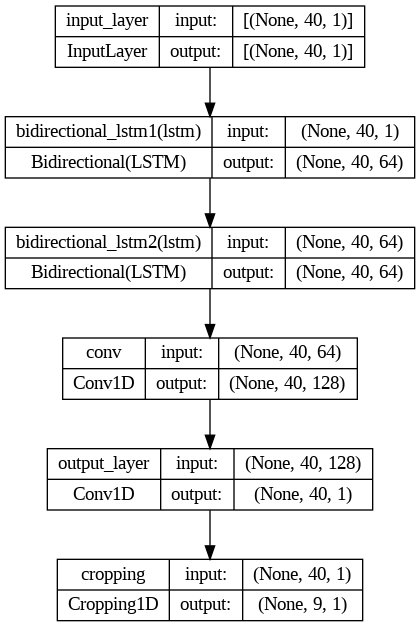

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
12375/12375 [==============================] - 183s 14ms/step - loss: 0.0658 - val_loss: 0.0714 - lr: 0.0010
Epoch 2/200
12375/12375 [==============================] - 178s 14ms/step - loss: 0.0655 - val_loss: 0.0710 - lr: 0.0010
Epoch 3/200
12375/12375 [==============================] - 186s 15ms/step - loss: 0.0655 - val_loss: 0.0712 - lr: 0.0010
Epoch 4/200
12375/12375 [==============================] - 178s 14ms/step - loss: 0.0655 - val_loss: 0.0709 - lr: 0.0010
Epoch 5/200
12375/12375 [==============================] - 175s 14ms/step - loss: 0.0655 - val_loss: 0.0711 - lr: 0.0010
Epoch 6/200
12375/12375 [==============================] - 175s 14ms/step - loss: 0.0654 - val_loss: 0.0709 - lr: 0.0010
Epoch 7/200
12375/12375 [==============================] - 173s 14ms/step - loss: 0.0654 - val_loss: 0.0715 - lr: 0.0010
Epoch 8/200
12375/12375 [==============================] - 170s 14ms/step - loss: 0.0654 - val_loss: 0.0712 - lr: 0.0010
Epoch 9/200
12375/12375 [=======

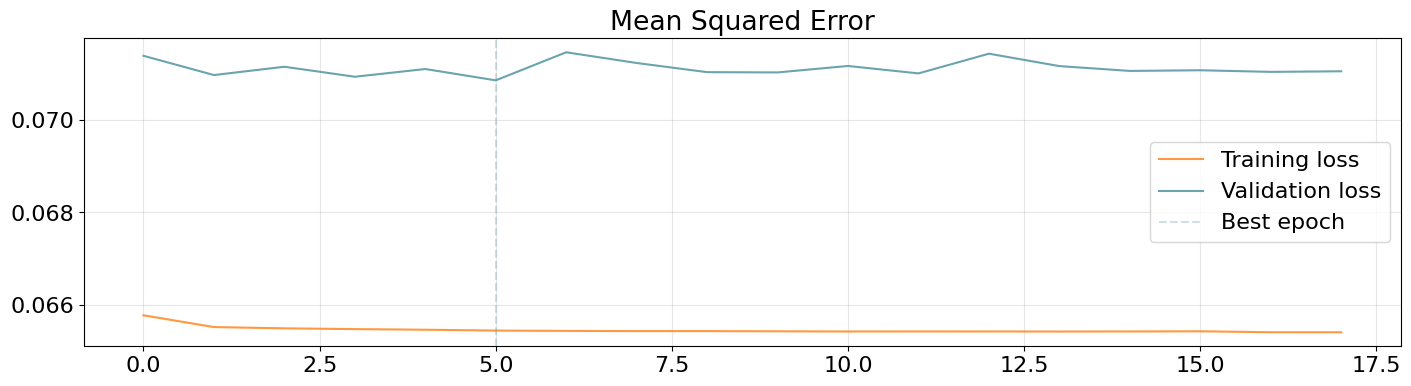

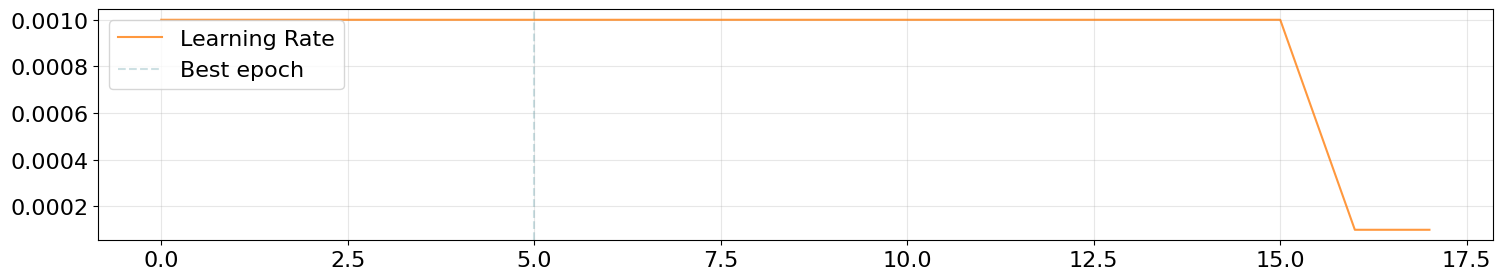

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('SimpleConvLSTM_3')
del model

In [ ]:
model = tfk.models.load_model('SimpleConvLSTM_3')

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (35096, 9, 1)
Mean Squared Error: 0.06788840889930725
Mean Absolute Error: 0.22178101539611816
